# Decision Trees

Imagine you have a set of data you would like to classify. One potential solution to this problem would be to attempt to define rules that would allow you to do quickly evaluate where the best locations to split the data are. Then, imagine you could add rules to either side of the decision. This idea of branching based on features is the fundamental concept behind a decision tree.

Let's visualize.

In [20]:
import pandas as pd
import numpy as np
import graphviz
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn import datasets
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

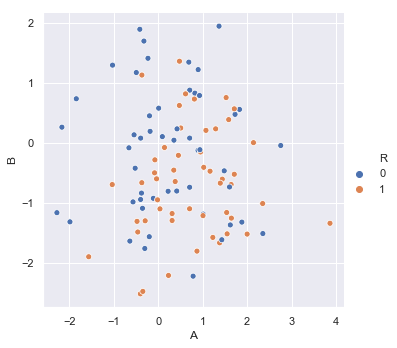

In [21]:
#Data Generation
AB, response = datasets.make_blobs(n_samples=100, centers=2, n_features=2, center_box=(-2,2))

data = {'A':[],'B':[],'R':[]}
for i in AB:
    data['A'].append(i[0])
    data['B'].append(i[1])
    data['R'].append(response[len(data['A'])-1])
data = pd.DataFrame(data)

sns.relplot(data=data, x='A',y='B', hue='R')

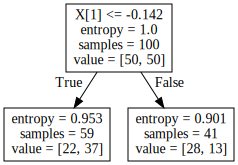

In [22]:
#One Deep
t = DecisionTreeClassifier(max_depth=1,criterion='entropy')
t.fit(data[['A','B']],data['R'])
graphviz.Source(tree.export_graphviz(t, out_file=None)) 

Entropy can be defined as a measure of homogeneity of a group where at $entropy=1$ you have an even mixture of observations and at $entropy=0$ you have a completely pure class. We won't dive to deep into the mathematics, but it can be mathematically expressed as $$entropy=\sum_{i=1}^n(-p_ilog_2(p_i))$$

In [ ]:
#One Deep Decision Surface
x_min, x_max = data['A'].min()-1, data['A'].max()+1
y_min, y_max = data['B'].min()-1, data['B'].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),np.arange(y_min, y_max, .01))
Z = t.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='RdBu')
plt.scatter(x=data['A'],y=data['B'],c=data['R'],cmap='RdBu',vmin=-.2, vmax=1.2,edgecolors='white')
plt.xlabel('A')
plt.ylabel('B')

Now, to get more precision, we can increase the level of depth.

In [ ]:
#Two Deep
t = DecisionTreeClassifier(max_depth=2,criterion='entropy')
t.fit(data[['A','B']],data['R'])
graphviz.Source(tree.export_graphviz(t, out_file=None)) 

In [ ]:
#One Deep Decision Surface
x_min, x_max = data['A'].min()-1, data['A'].max()+1
y_min, y_max = data['B'].min()-1, data['B'].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),np.arange(y_min, y_max, .01))
Z = t.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='RdBu')
plt.scatter(x=data['A'],y=data['B'],c=data['R'],cmap='RdBu',vmin=-.2, vmax=1.2,edgecolors='white')
plt.xlabel('A')
plt.ylabel('B')

In [ ]:
#Very Deep
t = DecisionTreeClassifier(max_depth=15,criterion='entropy')
t.fit(data[['A','B']],data['R'])
x_min, x_max = data['A'].min()-1, data['A'].max()+1
y_min, y_max = data['B'].min()-1, data['B'].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),np.arange(y_min, y_max, .01))
Z = t.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='RdBu')
plt.scatter(x=data['A'],y=data['B'],c=data['R'],cmap='RdBu',vmin=-.2, vmax=1.2,edgecolors='white')
plt.xlabel('A')
plt.ylabel('B')

Though we may increase the level of accuracy we can achieve (on our train data), what happens is that this is no longer fitting the general trends of the data, rather it is modeling the idiosyncrancries of our dataset. If we are to run a split and then test, we can find what the optimal level of depth is.

In [ ]:
fig, axs = plt.subplots(ncols=3,nrows=3,figsize=(15,15))

for j in range(3):
    #Data Generation
    AB, response = datasets.make_moons(n_samples=500,noise=0.2*(j+1))

    data = {'A':[],'B':[],'R':[]}
    for i in AB:
        data['A'].append(i[0])
        data['B'].append(i[1])
        data['R'].append(response[len(data['A'])-1])
    data = pd.DataFrame(data)

    xx, yy = np.meshgrid(np.arange(data['A'].min()-1, data['A'].max()+1, .01),
                         np.arange(data['B'].min()-1, data['B'].max()+1, .01))

    #Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(data[['A','B']], data['R'], test_size=0.2)

    #Predictions
    test_accuracy = []
    train_accuracy = []
    for i in range(30):
        t = DecisionTreeClassifier(max_depth=i+1,criterion='entropy')
        t.fit(X_train,y_train)
        train = cross_validate(t,X=X_test,y=y_test,scoring='roc_auc',
                               cv=3,return_train_score=True)
        test_accuracy.append(sum(train['test_score'])/len(train['test_score']))
        train_accuracy.append(sum(train['train_score'])/len(train['train_score']))
    accs = pd.DataFrame({'Test':test_accuracy, 'Train':train_accuracy}).set_index(np.linspace(1,31,30))

    #Create Plots  
    sns.scatterplot(data=data, x='A',y='B', hue='R',ax=axs[j,0]).set(title='Data Set')
    sns.lineplot(data=accs,ax=axs[j,1]).set(title='Accuracy over Depth')

    #Plot Contour
    bestDepth = test_accuracy.index(max(test_accuracy))
    t = DecisionTreeClassifier(max_depth=bestDepth+1,criterion='entropy')
    t.fit(X_train,y_train)
    Z = t.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    axs[j,2].contourf(xx, yy, Z, cmap='RdBu')
    axs[j,2].scatter(x=data['A'],y=data['B'],c=data['R'],cmap='RdBu',vmin=-.2, vmax=1.2,edgecolors='white')
    axs[j,2].set(xlabel='A',ylabel='B',title='Depth'+str(bestDepth+1))

You're not required to shoot in the dark as it come to customization of your tree. There exists something called a hyperparameter. Recall from our session on logistic regression that there are certain inputs you give your model that are not driven by the data - rather selected explicitly. In the case of the hyperparameter $C=\frac{1}{\lambda}$ we tune the level of punishment we give for complexity. This type of change results in a different model for each value we give. In the case of a decision tree, we have the following hyperparameters:

1) **max_depth**: This is what we see as a the maximum number of layers to go down in the tree, i.e. max splits

2) **min_samples_split**: The minimum number or ratio of samples required to have a split, default = 2

3) **min_samples_leaf**: The minimum number of samples in a leaf (i.e. end point), default = 1

4) **max_features**: The maximum number of features to include, default = unlimited

5) **max_leaf_nodes**: The maximum number of leafs allowed, default = unlimited

6) **criterion**: 'gini' or 'entropy' (Impurity or Information Gain)

There are no hard rules as to what works best - much of this is heavily dependent on the size and quality of your data. For example with millions of data points, you likely don't have a need for leafs with only one observation. Likewise, for small datasets, you will likely find some gain from having that be allowed. This part of model creation is more art than science and requires experimentation.

## Regression
You can also use this sort of method for regression - to predict a number rather than a category.

In [ ]:
#Generate Data
X = np.random.randn(200)*2
Y = list(map(lambda x: np.sin(x) + np.random.randn(1)[0]/10,X))
sns.relplot(x='X',y='Y',data=pd.DataFrame({'X':X,'Y':Y}))

In [ ]:
#Generate Decision Trees
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15,12))

c = 0
r = 0
for i in range(6):
    t = DecisionTreeRegressor(max_depth=i+1,min_samples_leaf=4)
    t.fit(np.array(X).reshape(-1,1),Y)
    score = t.score(np.array(X).reshape(-1,1),Y)
    sns.scatterplot(x='X',y='Y',data=pd.DataFrame({'X':X,'Y':Y}),
                    ax=axs[r,c]).set(title='Depth: '+str(i+1)+', Score: '+str(round(score,2)))
    p = t.predict(np.array(X).reshape(-1,1))
    sns.lineplot(x='X',y='P',data=pd.DataFrame({'X':X,'P':p}),ax=axs[r,c],color='r')
    if c == 2 :
        c=0
        r+=1
    else:
        c+=1

## Tuning the Hyperparameters

How we saw above where there is such a large number of tunable variables, we would like to develop a way to analyze the results of our changes to these, and eventually develop a programmatic method for evaluating our success. We will find that the process can be automated to an extent, but as it comes to the complexity accuracy tradeoff, it will become a game of experience and feeling.

Let's start by remembering our methods of tuning that we developed during the Logistic Regression session, but for a decision tree. For now, we consider only max_depth.

In [ ]:
#Generate Data
ABCD, response = datasets.make_blobs(n_samples=500, centers=2,
                                     n_features=4, center_box=(-2,2))
X_train, X_test, y_train, y_test = train_test_split(ABCD, response, test_size=0.2)

depths = [1,2,3,4,5,10,15,20,25,30]
accs = []
for i in depths:
    dtc = DecisionTreeClassifier(max_depth=i)
    dtc.fit(X_train,y_train)
    accs.append(dtc.score(X_test,y_test))
    
print('Scores:\n',pd.DataFrame({'Accuracy':accs},index=depths))

From this, we can quickly see how our data is behaving as we increase the depth of the trees. One thing we might also be interested in doing is evaluating this as a cross-validation to make sure that we are getting what is as close to a real number as possible. This may look something like the following.

In [ ]:
#Generate Data
ABCD, response = datasets.make_blobs(n_samples=500, centers=2,
                                     n_features=4, center_box=(-2,2))
X_train, X_test, y_train, y_test = train_test_split(ABCD, response, test_size=0.2)

depths = [1,2,3,4,5,10,15,20,25,30]
accs = []
for i in depths:
    dtc = DecisionTreeClassifier(max_depth=i)
    accs.append(cross_val_score(dtc,ABCD,response,cv=5).mean())
    
print('Scores:\n',pd.DataFrame({'Accuracy':accs},index=depths))

In the situation that we would like to evaluate more than just the depth of the tree, for example, also the min_samples_leaf, we can nest some for loops to create this behaviors. Let's see.

In [ ]:
#Generate Data
ABCD, response = datasets.make_blobs(n_samples=500, centers=2,
                                     n_features=4, center_box=(-2,2))
X_train, X_test, y_train, y_test = train_test_split(ABCD, response, test_size=0.2)

depths = [1,2,3,4,5,10,15,20,25,30]
leafs = [10,20,30,40,50,60]
accs = pd.DataFrame({'Depth':[],'Leaf Size':[],'Accuracy':[]})
for i in depths:
    for j in leafs:
        dtc = DecisionTreeClassifier(max_depth=i,min_samples_leaf=j)
        accs = accs.append({'Depth':i,'Leaf Size':j,
                     'Accuracy':cross_val_score(dtc,ABCD,response,cv=5).mean()},ignore_index=True)
    
print('Scores:\n',accs.sort_values('Accuracy',ascending=False))

We can continue to do this sort of methodology with $n$ nested for-loops for $n$ hyperparameters - but who has time for that. SKLearn has an in built feature to do exactly this sort of analysis. This method, called GridSearchCV does more or less exactly what we have been exploring, but with even more features. The way you pass the sets of values you would like to evaluate over is very similar to what we have done so far. Just like in doing our decision trees, we can see that the relationship between the number of hyperparameters and the computation time is exponential.

The time to perform these computations has the following form where $\mid P_k\mid$ is the length of the list of potential values for each parameter:

$$Computation\ Time=\left(\prod_{k=1}^{n}\mid P_k\mid\right)\times CV,\ n\ parameters$$

Let's do the same model as above, but with this new technique.

In [ ]:
ABCD, response = datasets.make_blobs(n_samples=500, centers=2,
                                     n_features=4, center_box=(-2,2))

dtc = DecisionTreeClassifier(criterion='entropy') #Note, you can declare a constant hyperparameter in your model
grid = {'max_depth':[1,2,3,4,5,10,15,20,25,30],
        'min_samples_leaf':[10,20,30,40,50,60]}

gs = GridSearchCV(dtc,grid,cv=5,verbose=True,return_train_score=False)
gs.fit(ABCD,response)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

It's important to note that this final method to declare scores uses a powerful tool called a regular expression where you can match text based on certain conditions. In our case, we are saying to match anything that starts with 'param_' and has at least one character after that, or something that is exactly 'mean_test_score'. What this gives us is each of our hyperparameters (which are now param_name).

Now, as an exercise, you will modify the code that we used to analyze two hyperparameters, and now also include the 'criterion' hyperparameter. Please consult the documentation for details on its possible values. Then print out exactly the same type of table as above with this new column

In [ ]:
ABCD, response = datasets.make_blobs(n_samples=500, centers=2,
                                     n_features=4, center_box=(-2,2))

dtc = DecisionTreeClassifier()
grid = {'max_depth':[1,2,3,4,5,10,15,20,25,30],
        'min_samples_leaf':[10,20,30,40,50,60],
        'new_param':['list','of','values']}

gs = GridSearchCV(dtc,grid,cv=5,verbose=True,return_train_score=False)
gs.fit(ABCD,response)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

It might be tempting to simply say, we want to maximize our accuracy so we choose the best performing model. Now, in some cases this may be what you end up doing, but more often, you will select a model that strikes a balance between complexity and accuracy.

Let's discuss a theoretical example. If you were to have a model that is evaluating max_depth and min_samples_leaf, what you would like to do is predict accurately and simply to avoid overfitting. One method for this is to do a cost-benefit analysis on the $\Delta complexity\ $to$\ \Delta accuracy$ relationship.

If our output from the grid search were to give us something like: (max_depth,min_samples_leaf,accuracy)=(10,50,.8),(15,50,.802) we must make a decision of which one is better. In thinking of this in terms of the above relationship, we have a percentage change of 50% in max_depth, with a resulting percentage change of 0.25% in accuracy. It should be a relatively safe bet that this change in accuracy would likely fall within a CI of accuracy based on our cross validation, or at least is so insignificant (not in the statistical way, but philosophical way) that including 50% more complexity is not worth it.

Based on this, let's go ahead and try to select what we think the best model might be out of scores. Note, there is no right answer to this question (though I would argue there are wrong answers).

In [ ]:
scores.head(20)

Now that we can understand decision trees and build a functional, well-tuned model, let's move on to something that is a little bit more complex.

# Random Forest
Just like how having one decision tree is a good way to model data, if you have many simultaneous trees, you can find even better predictive power, especially in situations where you have many features. Similarly to all of the models that we have seen, this can overfit as well. Let's go over the techniques for preparing, analyzing, and predicting.

In [ ]:
#Data Generation
AB, response = datasets.make_blobs(n_samples=1000, centers=2, n_features=5, center_box=(-2,2))
X_train, X_test, y_train, y_test = train_test_split(AB, response, test_size=0.2)

In this case, we are dealing with 2 classes, but the process can be generalized to n classes. Let's start with a single tree. This is declared using the n_estimators parameter meaning the number of trees we are using to do our estimation.

In [ ]:
rfc = RandomForestClassifier(max_depth=10,n_estimators=5)
rfc.fit(X_train,y_train)
print(rfc.score(X_test,y_test))

As we can see, this behaves exactly like any other model in SKLearn. In fact, there are some methods shared by nearly all models: fit and score. Using these, you can quickly change and evaluate different types of models, something that may come in useful over the following days while you fit your own models.

It should be noted that as we increase the complexity of our machine learning models, what we are going to find is that computation will take longer and longer. Oftentimes, in preparing my own models I will be tuning hyperparameters on a time scale measured in hours rather than in miliseconds as we have had so far. If your projects end up requiring a significant amount of processing power, we can consult on techniques to offload this CPU demand to the cloud - but for now we will simply suffer the waiting.

Below you will see some skeleton code for how to implement the grid search over our newfound parameter for the number of trees. It will be your task to flesh out this code.

In [ ]:
Xs, y = datasets.make_classification(n_samples=500,n_features=5,n_redundant=1,n_informative=4)

rfc = RandomForestClassifier() 
grid = {'param':['list'],
        'param':['list'],
        'param':['list']}

gs = GridSearchCV(rfc,grid,cv=5,verbose=True,return_train_score=False)
gs.fit(Xs,y)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

Just like how we saw the numerical prediction equivalent to DecisionTreeClassifier is DecisionTreeRegressor, the numerical predictor for RandomForestClassifier is RandomForestRegressor. There is really no difference between how you evaluate the accuracy of a classifier versus a regression model for RandomForest, and you gain a little more freedom than in pure regressions as the assumptions are relaxed. In general, so long as the model performs well for regression, all is okay.

Let's see a quick example of how we can do this.

In [ ]:
Xs, y = datasets.make_regression(n_samples=500,n_features=5,n_informative=4,noise=0.5)

rfr = RandomForestRegressor() 
grid = {'n_estimators':[1,2,3,4,5,10,15,20],
        'max_depth':[1,2,3,4,5,6,7,8,9,10],
        'min_samples_leaf':[10,20,30,40,50]}

gs = GridSearchCV(rfr,grid,cv=5,verbose=True,return_train_score=False)
gs.fit(Xs,y)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

As individuals, please now select which model you think performs the best based on what you can see in the scores and relative complexity - note that the number of estimators is a huge complexity factor.

Please then make a plot of the residuals for this graph by plotting the predicted values against the real values of y.

Now that we have built out well tuned models for both regression and classification, you are ready to go out and build for real!

Before that though, let's speak briefly on how we should go about evaluating our successes.

## Evaluating Accuracy
The below will illustrate three very similar measures of accuracy that you will select based on what sort of performance you care about in your model. Generally, the behavior of one will be highly correlated to the behavior of another with them often having exactly the same model all the way through to the thousands place.

In [ ]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(AB, response, test_size=0.2)

#Predictions
accuracy = []
precision = []
roc = []
for i in range(30):
    t = DecisionTreeClassifier(max_depth=i+1,criterion='entropy')
    t.fit(X_train,y_train)
    accuracy.append(accuracy_score(y_test,t.predict(X_test)))
    precision.append(precision_score(y_test,t.predict(X_test),average='macro'))
    roc.append(roc_auc_score(y_test,t.predict(X_test),average='macro'))

#Create Plots  
fig, axs = plt.subplots(ncols=3,figsize=(15,5))
sns.lineplot(x='Depth',y='Accuracy',data=pd.DataFrame({'Depth':np.linspace(1,31,30),'Accuracy':accuracy}),
             ax=axs[0]).set(title='Prediction Accuracy over Depth')
sns.lineplot(x='Depth',y='Precision',data=pd.DataFrame({'Depth':np.linspace(1,31,30),'Precision':precision}),
             ax=axs[1]).set(title='Prediction Precision over Depth')
sns.lineplot(x='Depth',y='AUC',data=pd.DataFrame({'Depth':np.linspace(1,31,30),'AUC':roc}),
             ax=axs[2]).set(title='Prediction AUC over Depth')

What we see are three different calculations for how to evaluate the success of a model.

$$tp=True\ Positive,\ tn=True\ Negative,\ fp=False\ Positive,\ fn=False\ Negative$$

$$Accuracy = \frac{tp+tn}{tp+tn+fp+fn}$$

$$Precision = \frac{tp}{tp+fp}$$

$$AUC=Area\ Under\ ROC\ Curve$$

Let us quickly also review what the ROC AUC means.

In [ ]:
Xs, y = datasets.make_moons(n_samples=500,noise=0.3)

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

#Predictions
rfc = RandomForestClassifier(max_depth=10,n_estimators=5).fit(X_train,y_train)
aucscore = metrics.roc_auc_score(rfc.predict(X_test),y_test)

##Computing false and true positive rates
fpr, tpr,_= metrics.roc_curve(rfc.predict(X_test),y_test,drop_intermediate=False)

##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve AUC = '+str(aucscore.round(4)))
plt.show()

## Visualizing Random Forest Model Selection
The below heatmaps show each of the measures of accuracy based on a set of heatmaps that have color representing the predictive capability of the model. This is an easy way of being able to quickly spot which families of models are likely going to be the best performing. As you move away from the origin, you would like to maximize the green while minimizing the distance you have to travel.

In [ ]:
#Train/Test Split
AB, response = datasets.make_moons(n_samples=500,noise=0.5)
X_train, X_test, y_train, y_test = train_test_split(AB, response, test_size=0.40)

scores = {'Accuracy':[],'Precision':[],'ROC':[]}
for i in range(30):
    scores_acc = []
    scores_pre = []
    scores_roc = []
    for j in range(20):
        rf = RandomForestClassifier(n_estimators=i+1,max_depth=j+1)
        rf.fit(X_train,y_train)
        splits=3
        scores_acc.append(accuracy_score(y_test,rf.predict(X_test)))
        scores_pre.append(precision_score(y_test,rf.predict(X_test),average='micro'))
        scores_roc.append(roc_auc_score(y_test,rf.predict(X_test),average='micro'))
    scores['Accuracy'].append(scores_acc)
    scores['Precision'].append(scores_pre)
    scores['ROC'].append(scores_roc)

In [ ]:
fig, axs = plt.subplots(ncols=3,figsize=(16,10))
cbar_ax = fig.add_axes([.91,.3,.03,.4])

for i in range(3):
    sns.heatmap(scores[list(scores.keys())[i]],xticklabels=np.arange(20)+1,yticklabels=np.arange(30)+1,
                cmap='RdYlGn',ax=axs[i],cbar = i==0,cbar_ax=None if i else cbar_ax)
    axs[i].set(title=list(scores.keys())[i],xlabel='Tree Depth',ylabel='Number of Trees')
    axs[i].set_xticklabels(np.arange(20)+1,rotation=0)
    axs[i].invert_yaxis()

fig.tight_layout(rect=[0, 0, .9, 1])

You can now select and predict based on whichever tree you feel may give you the best outcome. In our case, accuracy is likely ging to be the deciding factor.

## A Final Test

We would like to now be able to check our understanding. Please take 15-30 minutes to build out each of these regression and classification models using the automated tuning system and select what you think the best model is and why. Then please discuss in your group why you chose that model.

In [ ]:
Xs, y = datasets.make_classification(n_samples=500,n_features=5,n_redundant=0)

In [ ]:
Xs, y = datasets.make_regression(n_samples=500,n_features=5,noise=0.5)